FTEC5580 Project 2 Classification Tree \
Name : Man Yat Fu \
SID : 1155109353

In [1]:
install.packages("C50")

Installing package into ‘/work/.R/library’
(as ‘lib’ is unspecified)



In [2]:
library(readr)
library(caret)
library(scales)
library(dplyr)
library(mboost)
library(naivebayes)
library(MASS)
library(glmnet)
library(Matrix)
library(plyr)
library(gbm)
library(leaps)
library(C50)


Loading required package: ggplot2

Loading required package: lattice


Attaching package: ‘scales’


The following object is masked from ‘package:readr’:

    col_factor



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: parallel

Loading required package: stabs


Attaching package: ‘mboost’


The following object is masked from ‘package:ggplot2’:

    %+%


naivebayes 0.9.7 loaded


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: Matrix

Loaded glmnet 4.1-4


Attaching package: ‘glmnet’


The following object is masked from ‘package:mboost’:

    Cindex


------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr 

In [3]:
data <- read.table("UCI_Credit_Card.csv",sep=",",skip=2,header=FALSE)
header <- scan("UCI_Credit_Card.csv",sep=",",nlines=2,what=character())
###change the col names
names <- c("ID", "given.credit", "Gender", "Education", "marital.status", "Age",
"Pay_Delay_Sept", "Pay_Delay_Aug", "Pay_Delay_Jul",
"Pay_Delay_Jun","Pay_Delay_May", "Pay_Delay_Apr",
"Bill_Amt_Sept", "Bill_Amt_Aug", "Bill_Amt_Jul",
"Bill_Amt_Jun", "Bill_Amt_May", "Bill_Amt_Apr",
"Pay_Amt_Sept", "Pay_Amt_Aug", "Pay_Amt_Jul",
"Pay_Amt_Jun", "Pay_Amt_May", "Pay_Amt_Apr",
"Default_payment_next_month")
names(data) <- names
set.seed(12)
n = length(data$ID)
index <- 1:nrow(data)
testindex <- sample(index, trunc(n)/4)
test.data <- data[testindex,]
train.data <- data[-testindex,]


In [4]:
train.data[3:5] <- lapply(train.data[3:5], as.factor)
train.data[7:12] <- lapply(train.data[7:12], as.factor)
train.data$Default_payment_next_month <- as.factor(train.data$Default_payment_next_month)
summary(train.data)


       ID         given.credit     Gender    Education marital.status
 Min.   :    3   Min.   :  10000   1: 8919   0:   11   0:   41       
 1st Qu.: 7565   1st Qu.:  50000   2:13581   1: 7967   1:10187       
 Median :15096   Median : 140000             2:10494   2:12014       
 Mean   :15065   Mean   : 167249             3: 3678   3:  258       
 3rd Qu.:22554   3rd Qu.: 240000             4:   85                 
 Max.   :30000   Max.   :1000000             5:  223                 
                                             6:   42                 
      Age        Pay_Delay_Sept  Pay_Delay_Aug   Pay_Delay_Jul  
 Min.   :21.00   0      :11085   0      :11833   0      :11856  
 1st Qu.:28.00   -1     : 4261   -1     : 4513   -1     : 4460  
 Median :34.00   1      : 2752   2      : 2938   -2     : 3043  
 Mean   :35.46   -2     : 2058   -2     : 2824   2      : 2842  
 3rd Qu.:41.00   2      : 1980   3      :  240   3      :  182  
 Max.   :79.00   3      :  254   4      :   82   4

In [5]:
nrow(train.data[train.data$`given.credit` >= 500000,])
nrow(train.data[train.data$`given.credit` >= 500000,]) / nrow(train.data)

[1] 687

[1] 0.03053333

In [6]:
subset_td <- train.data[train.data$`given.credit` < 500000,]
nrow(subset_td)  #21813

[1] 21813

<h2> Data Prceossing

In [7]:
#Remove some incorrect data to avoid confusion, like -2,-1 of delay payment change to 0.
for(i in 1:nrow(data)){
if(data$Pay_Delay_Sept[i] == -2 | data$Pay_Delay_Sept[i] == -1 ){
data$Pay_Delay_Sept[i] = 0
}
if(data$Pay_Delay_Aug[i] == -1 | data$Pay_Delay_Aug[i] == -2 ){
data$Pay_Delay_Aug[i] = 0
}
if(data$Pay_Delay_Jul[i] == -1 | data$Pay_Delay_Jul[i] == -2){
data$Pay_Delay_Jul[i] = 0
}
if(data$Pay_Delay_Jun[i] == -1 | data$Pay_Delay_Jun[i] == -2){
data$Pay_Delay_Jun[i] = 0
}
if(data$Pay_Delay_May[i] == -1 | data$Pay_Delay_May[i] == -2){
data$Pay_Delay_May[i] = 0
}
if(data$Pay_Delay_Apr[i] == -1 | data$Pay_Delay_Apr[i] == -2 ){
data$Pay_Delay_Apr[i] = 0
}
}
data$`marital.status`[which(data$`Martial Status` == 0)] <- 3
data$Education[which(data$Education == 0 | data$Education == 5 |
data$Education == 6)] <- 4
data$Default_payment_next_month <- as.factor(data$Default_payment_next_month)
set.seed(111)
n = length(data$ID)
index <- 1:nrow(data)
testindex <- sample(index, trunc(n)/4)
test.data <- data[testindex,]
train.data <- data[-testindex,]
train.class <- train.data$Default_payment_next_month
test.class <- test.data$Default_payment_next_month

In [8]:
model1 <- glm(Default_payment_next_month ~ ., data = train.data,
family = "binomial")
summary(model1)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Default_payment_next_month ~ ., family = "binomial", 
    data = train.data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.0321  -0.6032  -0.5300  -0.3275   3.5757  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)    -1.111e+00  1.474e-01  -7.534 4.92e-14 ***
ID             -1.437e-06  2.093e-06  -0.686 0.492430    
given.credit   -1.485e-06  1.796e-07  -8.268  < 2e-16 ***
Gender         -1.161e-01  3.674e-02  -3.161 0.001574 ** 
Education      -8.712e-02  2.612e-02  -3.335 0.000852 ***
marital.status -1.288e-01  3.813e-02  -3.377 0.000734 ***
Age             5.370e-03  2.139e-03   2.510 0.012063 *  
Pay_Delay_Sept  8.946e-01  2.919e-02  30.651  < 2e-16 ***
Pay_Delay_Aug   4.007e-02  3.063e-02   1.308 0.190769    
Pay_Delay_Jul   1.161e-01  3.281e-02   3.539 0.000402 ***
Pay_Delay_Jun   1.204e-01  3.659e-02   3.290 0.001000 ** 
Pay_Delay_May   7.761e-02  3.961e-02   1.960 0.050034 .  
Pay_Delay_Apr   1.4

<h2>Training Set

In [9]:
###for training set
train.data$avg_bill <- (train.data$Bill_Amt_Sept + train.data$Bill_Amt_Aug +
                        train.data$Bill_Amt_Jul +
                        train.data$Bill_Amt_Jun + train.data$Bill_Amt_May +
                        train.data$Bill_Amt_Apr)/ 6
train.data$avg_payment <- (train.data$Pay_Amt_Sept + train.data$Pay_Amt_Aug +
                            train.data$Pay_Amt_Jul +
                            train.data$Bill_Amt_Jun + train.data$Bill_Amt_May +
                           train.data$Bill_Amt_Apr) /6
train.data$numOfMonthsDelayed <- NA
for(i in 1:nrow(train.data)){
    train.data$numOfMonthsDelayed[i] <- train.data$Pay_Delay_Sept[i] +
    train.data$Pay_Delay_Aug[i]
    + train.data$Pay_Delay_Jul[i] + train.data$Pay_Delay_Jun[i] +
    train.data$Pay_Delay_May[i] +train.data$Pay_Amt_Apr[i]
    }




<h2>Testing Set

In [10]:
test.data$avg_bill <- (test.data$Bill_Amt_Sept + test.data$Bill_Amt_Aug +
                        test.data$Bill_Amt_Jul +
                        test.data$Bill_Amt_Jun + test.data$Bill_Amt_May +
                        test.data$Bill_Amt_Apr)/ 6
test.data$avg_payment <- (test.data$Pay_Amt_Sept + test.data$Pay_Amt_Aug +
                            test.data$Pay_Amt_Jul +
                            test.data$Bill_Amt_Jun + test.data$Bill_Amt_May +
                            test.data$Bill_Amt_Apr) /6
test.data$numOfMonthsDelayed <- NA
for(i in 1:nrow(test.data)){
    test.data$numOfMonthsDelayed[i] <- test.data$Pay_Delay_Sept[i] +
    test.data$Pay_Delay_Aug[i]
    + test.data$Pay_Delay_Jul[i] + test.data$Pay_Delay_Jun[i] +
    test.data$Pay_Delay_May[i] +test.data$Pay_Amt_Apr[i]
}

In [11]:
myvars <- c( "given.credit","Age", "Gender", "Education",
"marital.status", "avg_bill", "avg_payment",
"numOfMonthsDelayed")
train.data.2 <- train.data[myvars]
test.data.2 <- test.data[myvars]

In [12]:
model2 <- glm(train.class ~ ., data = train.data.2, family = "binomial")
summary(model2)


Call:
glm(formula = train.class ~ ., family = "binomial", data = train.data.2)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.7727  -0.6117  -0.5428  -0.4125   2.4421  

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)        -1.073e+00  1.417e-01  -7.574 3.63e-14 ***
given.credit       -2.033e-06  1.719e-07 -11.826  < 2e-16 ***
Age                 5.498e-03  2.108e-03   2.608 0.009109 ** 
Gender             -1.063e-01  3.614e-02  -2.941 0.003267 ** 
Education          -9.864e-02  2.567e-02  -3.842 0.000122 ***
marital.status     -1.356e-01  3.748e-02  -3.618 0.000296 ***
avg_bill            4.401e-06  1.126e-06   3.907 9.33e-05 ***
avg_payment        -9.131e-06  2.262e-06  -4.037 5.42e-05 ***
numOfMonthsDelayed  5.685e-01  1.193e-02  47.639  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 23804  on 22499  degrees o

In [13]:
outbackward <- regsubsets(train.class ~., data = train.data.2,
method = "backward")
summary(outbackward)

Subset selection object
Call: regsubsets.formula(train.class ~ ., data = train.data.2, method = "backward")
8 Variables  (and intercept)
                   Forced in Forced out
given.credit           FALSE      FALSE
Age                    FALSE      FALSE
Gender                 FALSE      FALSE
Education              FALSE      FALSE
marital.status         FALSE      FALSE
avg_bill               FALSE      FALSE
avg_payment            FALSE      FALSE
numOfMonthsDelayed     FALSE      FALSE
1 subsets of each size up to 8
Selection Algorithm: backward
         given.credit Age Gender Education marital.status avg_bill avg_payment
1  ( 1 ) " "          " " " "    " "       " "            " "      " "        
2  ( 1 ) "*"          " " " "    " "       " "            " "      " "        
3  ( 1 ) "*"          " " " "    " "       "*"            " "      " "        
4  ( 1 ) "*"          " " "*"    " "       "*"            " "      " "        
5  ( 1 ) "*"          " " "*"    "*"       "*" 

In [14]:
accuracy.mat <- matrix(nrow = 18, ncol = 4)
colnames(accuracy.mat) <- c("Model", "Train Accuracy", "Test Accuracy", "Time (Seconds)")

In [15]:
library(C50)
start.time <- Sys.time()
C50tree_full <- C5.0(train.class ~. ,data= train.data.2)
C50tree_full.train.acc <- (16788 + 1685) / (16788 + 758 + 3269 + 1685)
C50tree_full.test <- predict(C50tree_full, newdata = test.data.2)
C50tree_full.test.acc <- mean(C50tree_full.test == test.class)
end.time <- Sys.time()
t <- end.time - start.time
accuracy.mat[1,] <- c("C50 Full Model",
C50tree_full.train.acc, C50tree_full.test.acc,t)

In [16]:
#reduce model
tart.time <- Sys.time()
C50tree_reduced <- C5.0(train.class ~ `given.credit` +
                    `marital.status` + numOfMonthsDelayed,data= train.data.2)
C50tree_reduced.train.acc <- (16779 + 1672) / (16779 + 767 + 3282 + 1672)
C50tree_reduced.test <- predict(C50tree_reduced, newdata = test.data.2)
C50tree_reduced.test.acc <- mean(C50tree_reduced.test == test.class)
end.time <- Sys.time()
t <- end.time - start.time
accuracy.mat[2,] <- c("C50 Reduced Model", C50tree_reduced.train.acc,
                        C50tree_reduced.test.acc, t)

In [17]:
#boosting full model
start.time <- Sys.time()
C50tree_full_boost <- C5.0(train.class~. ,data= train.data.2, trials = 3)
C50tree_full_boost.train.acc <- (16798 + 1681) / 22500
C50tree_full_boost.test <- predict(C50tree_full_boost, newdata = test.data.2)
C50tree_full_boost.test.acc <- mean(C50tree_full_boost.test == test.class)
end.time <- Sys.time()
t <- end.time - start.time
accuracy.mat[3,] <- c("C50 Full Model with boosting",
C50tree_full_boost.train.acc, C50tree_full_boost.test.acc, t)

In [18]:
#boosting reduced model
start.time <- Sys.time()
C50tree_reduced_boost <- C5.0(train.class~ `given.credit` +
                                `marital.status` + numOfMonthsDelayed ,
                                data= train.data.2, trials = 3)
C50tree_reduced_boost.train.acc <- (16779 + 1672) / 22500
C50tree_reduced_boost.test <- predict(C50tree_reduced_boost, newdata = test.data.2)
C50tree_reduced_boost.test.acc <- mean(C50tree_reduced_boost.test == test.class)
end.time <- Sys.time()
t <- end.time - start.time
accuracy.mat[4,] <- c("C50 reduced Model with boosting",
                        C50tree_reduced_boost.train.acc, C50tree_reduced_boost.test.acc, t)

In [19]:
accuracy.mat


Model,Train Accuracy,Test Accuracy,Time (Seconds)
C50 Full Model,0.821022222222222,0.816908921189492,0.734351634979248
C50 Reduced Model,0.820044444444444,0.816908921189492,1.09065914154053
C50 Full Model with boosting,0.821288888888889,0.816375516735565,0.835496425628662
C50 reduced Model with boosting,0.820044444444444,0.816908921189492,0.350750207901001
NA,NA,NA,NA
NA,NA,NA,NA
NA,NA,NA,NA
NA,NA,NA,NA
NA,NA,NA,NA
NA,NA,NA,NA


In [20]:
summary(C50tree_full)



Call:
C5.0.formula(formula = train.class ~ ., data = train.data.2)


C5.0 [Release 2.07 GPL Edition]  	Sat Apr 30 07:37:21 2022
-------------------------------

Class specified by attribute `outcome'

Read 22500 cases (9 attributes) from undefined.data

Decision tree:

numOfMonthsDelayed <= 1:
:...avg_bill > 1155.333: 0 (15743/1944)
:   avg_bill <= 1155.333:
:   :...Age <= 55: 0 (2586/648)
:       Age > 55:
:       :...avg_bill <= 30.33333: 1 (34/8)
:           avg_bill > 30.33333: 0 (68/18)
numOfMonthsDelayed > 1:
:...Education > 3: 0 (27/5)
    Education <= 3:
    :...numOfMonthsDelayed > 3: 1 (1730/499)
        numOfMonthsDelayed <= 3:
        :...numOfMonthsDelayed > 2: 0 (1279/544)
            numOfMonthsDelayed <= 2:
            :...avg_bill <= 10316.67: 0 (383/145)
                avg_bill > 10316.67: 1 (650/224)


Evaluation on training data (22500 cases):

	    Decision Tree   
	  ----------------  
	  Size      Errors  

	     9 4035(17.9%)   <<


	   (a)   (b)    <-classifi

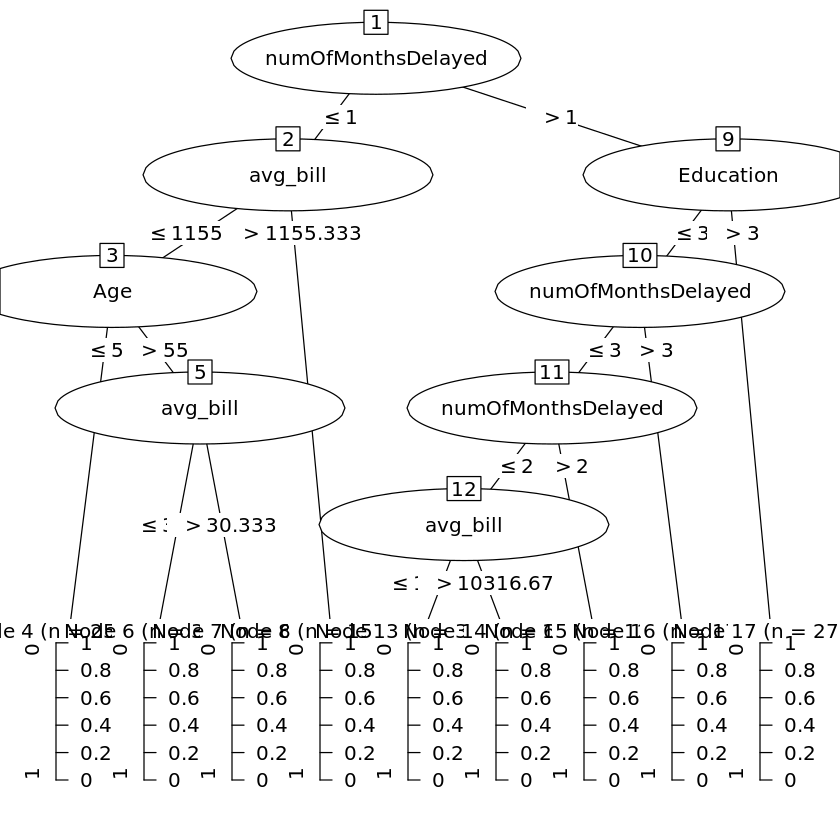

In [21]:
C50tree_full.train.acc <- (16788 + 1685) / (16788 + 758 + 3269 + 1685)
plot(C50tree_full)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d5b7d61b-de48-4673-ae85-198a21ec9e3f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>